In [129]:
import numpy as np

In [130]:
class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None        

    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

#### Rectifier Linear Activation Layer (ReLU)

In [131]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

In [132]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

#### Define Cross Entropy Loss

In [133]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

In [134]:
from keras.datasets import mnist
from keras.utils import np_utils


(train_features, train_targets), (test_features, test_targets) = mnist.load_data()


train_features = train_features.reshape(60000, 784)
print(train_features.shape)
test_features = test_features.reshape(10000, 784)
print(test_features.shape)


# # normalize inputs from 0-255 to 0-1
train_features = train_features / 255.0
test_features = test_features / 255.0

print(train_targets.shape)
print(test_targets.shape)

X_train = train_features
y_train = train_targets

X_val = test_features
y_val = test_targets


(60000, 784)
(10000, 784)
(60000,)
(10000,)


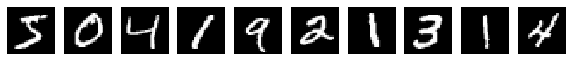

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()

In [136]:
class NN():
    def __init__(self, lossfunc=CrossEntropy(), mode='train'):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        self.mode = mode
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        nextgrad = self.loss_func.backward(out,y)
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        p = softmax(X)
        return np.argmax(p, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        p = softmax(X)
        return p
    
    def clear_grad_param(self):
        self.grads = []

#### Defining update function (SGD with momentum)

In [137]:
def update_params(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] - learning_rate * g[i]
            p[i] += v[i]

In [138]:
# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))
        
    return minibatches

#### The training loop

In [139]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update_params(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = np.array([], dtype="int64")
        y_val_pred = np.array([], dtype="int64")
        y_train1 = []
        y_vall = []
        for i in range(0, m_train, minibatch_size):
            X_tr = X_train[i:i + minibatch_size, : ]
            y_tr = y_train[i:i + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for i in range(0, m_val, minibatch_size):
            X_va = X_val[i:i + minibatch_size, : ]
            y_va = y_val[i:i + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)

        mean_train_loss = sum(loss_batch) / float(len(loss_batch))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net

In [140]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

In [141]:
from random import shuffle

input_dim = X_train.shape[1]
iterations = 10
learning_rate = 0.1
hidden_nodes = 32
output_nodes = 10

nn = NN()
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(ReLU())
nn.add_layer(Linear(hidden_nodes, output_nodes))

nn = train(nn, X_train, y_train, minibatch_size=200, epoch = 10, learning_rate=learning_rate, X_val=X_val, y_val=y_val)

Loss = 0.48755990068218685 | Training Accuracy = 0.9381166666666667 | Val Loss = 0.11966338232166268 | Val Accuracy = 0.9366
Loss = 0.18089931460377315 | Training Accuracy = 0.957 | Val Loss = 0.07707189167589312 | Val Accuracy = 0.9541
Loss = 0.13418472286757374 | Training Accuracy = 0.96835 | Val Loss = 0.042494696043868636 | Val Accuracy = 0.962
Loss = 0.11078063627641484 | Training Accuracy = 0.9707 | Val Loss = 0.033607762649984725 | Val Accuracy = 0.9623
Loss = 0.09682899014460995 | Training Accuracy = 0.9706833333333333 | Val Loss = 0.03044574716599489 | Val Accuracy = 0.9604
Loss = 0.0868328547827688 | Training Accuracy = 0.9715833333333334 | Val Loss = 0.026621312537132038 | Val Accuracy = 0.9615
Loss = 0.07922587564463619 | Training Accuracy = 0.9721833333333333 | Val Loss = 0.026927097368782803 | Val Accuracy = 0.9604
Loss = 0.07435006835457149 | Training Accuracy = 0.97395 | Val Loss = 0.02895926809115212 | Val Accuracy = 0.9597
Loss = 0.07014696397167437 | Training Accurac

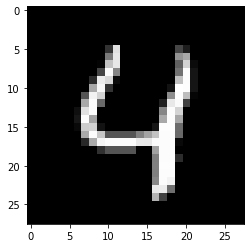

In [170]:
plt.imshow(X_val[4].reshape(28,28), cmap='gray')

In [171]:
prediction = nn.predict_scores(X_val[4])[0]

In [172]:
prediction

array([8.21607772e-08, 8.96688318e-05, 1.81752135e-06, 1.06435534e-07,
       9.97906089e-01, 4.08327788e-08, 6.55437243e-07, 1.34608780e-04,
       6.94180536e-09, 1.86692389e-03])

In [173]:
np.argmax(prediction)

4